In [1]:
!nvidia-smi

Sun Jan  2 18:16:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   42C    P0    42W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   

In [2]:
import os
import copy
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [3]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [4]:
from models.backbone import ResNetBackbone
from models.head import MLPHead

from tasks.moco import MemoryQueue

from datasets.cifar import CIFAR10ForMoCo, CIFAR10ForCLAP
from datasets.transforms import MoCoAugment

In [5]:
# Instantiate model (ResNet backbone, MLP head, and memory queue)
encoder = ResNetBackbone(name='resnet50', data='cifar10', in_channels=3)
head = MLPHead(in_channels=encoder.out_channels, num_features=128)
net_q = nn.Sequential()
net_q.add_module('encoder', encoder)
net_q.add_module('head', head)
net_k = copy.deepcopy(net_q)
net_t = copy.deepcopy(net_k)
queue = MemoryQueue(size=(128, 4096))

# Load trained model from checkpoint
ckpt_file = "checkpoints/cifar10/uncl/resnet50/2022-01-02_00:50:32/ckpt.500.pth.tar"
ckpt = torch.load(ckpt_file, map_location='cpu')
net_q.encoder.load_state_dict(ckpt['encoder'])
net_q.head.load_state_dict(ckpt['head'])
net_k.load_state_dict(ckpt['net_k'])
net_t.load_state_dict(ckpt['net_t'])
queue.load_state_dict(ckpt['queue'])

<All keys matched successfully>

In [6]:
# Configure dataset
train_transform = MoCoAugment(size=(32, 32), data='cifar10')
train_set = CIFAR10ForCLAP(root='data/cifar10', train=True, 
                           query_transform=train_transform,
                           key_transform=train_transform,
                           teacher_transform=train_transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=False)

In [7]:
device = 'cuda:0'
net_q.to(device); net_q.eval()
net_k.to(device); net_k.eval()
net_t.to(device); net_t.eval()
queue.to(device);

In [8]:
def random_maskout(x: torch.FloatTensor, p: float = 0.2, val: float = 0.0):
    m = torch.rand_like(x).le(p)
    return x.masked_fill(m, val)

In [9]:
def get_similarities(query: torch.FloatTensor, negatives: torch.FloatTensor, n: int):
    query = query.unsqueeze(0).repeat(n, 1, 1)
    query = random_maskout(query, p=0.2, val=0.0)
    query = F.normalize(query, p=2, dim=2)
    negatives = negatives.unsqueeze(0).repeat(n, 1, 1)
    negatives = random_maskout(negatives, p=0.2, val=0.0)
    negatives = F.normalize(negatives, p=2, dim=2)
    return torch.einsum('nbf,nfq->nbq', *[query, negatives])

In [10]:
def entropy_with_logits(logits: torch.FloatTensor, softmax_dim: int = 1):
    probs = F.softmax(logits, dim=softmax_dim).add(1e-7)
    entropy = -probs.mul(probs.log()).sum(dim=softmax_dim)
    return entropy

In [11]:
query_temperature = 0.2
teacher_temperature = 0.5

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        x_q, x_k, x_t = batch['x1'].to(device), batch['x2'].to(device), batch['x3'].to(device)
        z_t = F.normalize(net_t(x_t), dim=1)
        similarities = get_similarities(query=z_t, negatives=queue.buffer, n=128)
        similarities.div_(teacher_temperature)
        entropies = entropy_with_logits(similarities, softmax_dim=1)
        if i > 1:
            break

In [12]:
print(f"0.9 quantile: {torch.quantile(entropies.mean(dim=0), q=0.9):.3f}")

0.9 quantile: 5.545


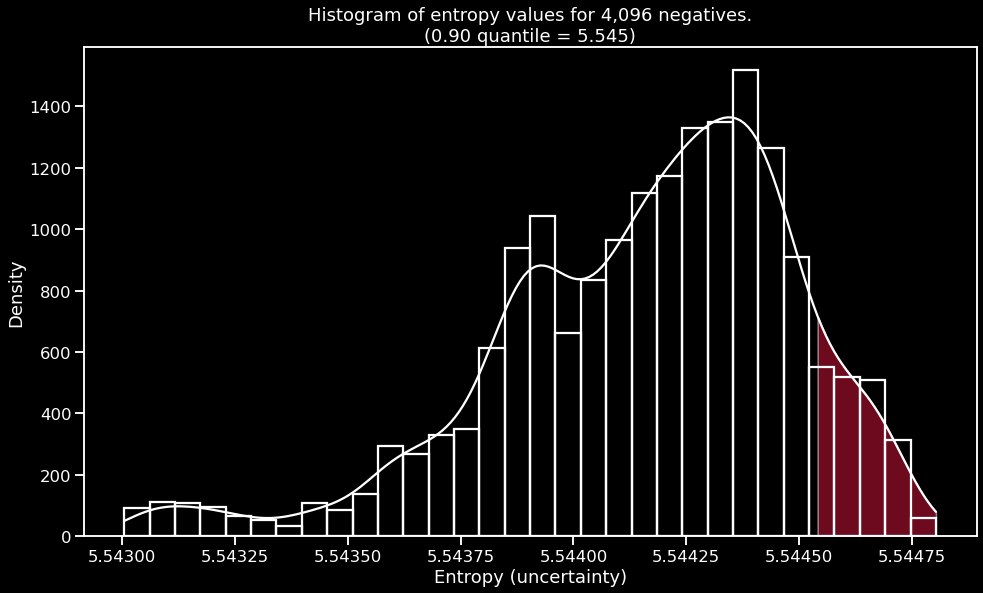

In [13]:
# Histogram of uncertainties

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.histplot(entropies.mean(dim=0).detach().cpu().numpy(), stat='density', fill=False, kde=True, color='white', ax=ax)

xs, ys = ax.get_lines()[-1].get_data()
quantile = 0.9
threshold = torch.quantile(entropies.mean(dim=0), q=quantile).item()
mask = xs > threshold
xs, ys = xs[mask], ys[mask]
ax.fill_between(x=xs, y1=ys, alpha=0.5, facecolor='crimson')

ax.set_xlabel('Entropy (uncertainty)')
ax.set_ylabel('Density')
ax.set_title(f'Histogram of entropy values for {entropies.size(1):,} negatives.\n({quantile:.2f} quantile = {threshold:.3f})')
plt.show(fig)

In [16]:
# UMap visualization
umap_reducer = umap.UMAP(n_neighbors=15)
teacher_embeddings = umap_reducer.fit_transform(z_t.detach().cpu().numpy())
queue_embeddings = umap_reducer.transform(queue.features.T.detach().cpu().numpy())

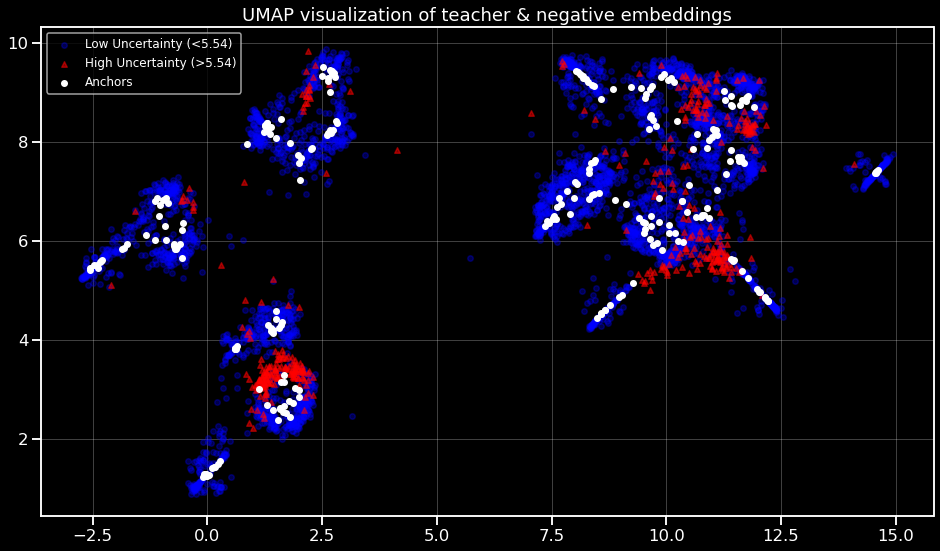

In [17]:
ent = entropies.mean(dim=0).detach().cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.scatter(queue_embeddings[ent < threshold, 0], queue_embeddings[ent < threshold, 1],
           marker='o', color='blue', alpha=0.3, s=30, label=f'Low Uncertainty (<{threshold:.2f})')
ax.scatter(queue_embeddings[ent >= threshold, 0], queue_embeddings[ent >= threshold, 1],
           marker='^', color='red', alpha=0.5, s=30, label=f'High Uncertainty (>{threshold:.2f})')
ax.scatter(teacher_embeddings[:, 0], teacher_embeddings[:, 1],
           marker='o', color='w', s=30, label='Anchors')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.5, linewidth=0.5)
ax.set_title('UMAP visualization of teacher & negative embeddings')
plt.show(fig)